In [31]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys
sys.path.remove('/home/jovyan/.imgenv-vasilyev-0/lib/python3.7/site-packages')
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-experiments/')
sys.path.append('/home/jovyan/klenitskiy/repos/seqrec-datasets')

In [32]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary, RichProgressBar
from replay.splitters import ColdUserRandomSplitter, NewUsersSplitter
from torch import nn
from torch.utils.data import DataLoader
from transformers import GPT2Config, GPT2Model

from seqrec_experiments.metrics import Evaluator
from seqrec_experiments.lightning.datasets import CausalLMDataset, CausalLMPredictionDataset, PaddingCollateFn
from seqrec_experiments.lightning.models import GPT4Rec
from seqrec_experiments.lightning.modules import SeqRec
from seqrec_experiments.postprocess import preds2recs
from seqrec_experiments.utils import extract_validation_history

from preprocessing.preparation import get_last_item, remove_last_item

In [33]:
DATA_PATH = '/home/jovyan/klenitskiy/data/ml-1m/ratings.csv'

DATA_SAVE_PATH = 'data/ml-1m'
MODEL_SAVE_PATH = 'models/ml-1m'

## Prepare data

In [34]:
df = pd.read_csv(DATA_PATH)
df = df.sort_values(['user_id', 'timestamp'])
df.timestamp = pd.to_datetime(df.timestamp).astype(int) / 10**9
print(df.shape)
print(df.user_id.nunique(), df.item_id.nunique())
df.head()

(1000209, 4)
6040 3706


,user_id,item_id,rating,timestamp
0,1,3186,4,978300019.0
1,1,1270,5,978300055.0
2,1,1721,4,978300055.0
3,1,1022,5,978300055.0
4,1,2340,3,978300103.0


In [37]:
test_splitter = NewUsersSplitter(
    test_size=0.1, drop_cold_items=True, query_column="user_id")
train, test = test_splitter.split(df)

validation_splitter = ColdUserRandomSplitter(
    test_size=0.4, drop_cold_items=True, query_column="user_id", seed=42)
train, validation = validation_splitter.split(train)

In [39]:
print(train.shape, train.user_id.nunique(), train.item_id.nunique())
print(validation.shape, validation.user_id.nunique(), validation.item_id.nunique())
print(test.shape, test.user_id.nunique(), test.item_id.nunique())

(487093, 4) 3262 3597
(319903, 4) 2174 3454
(91422, 4) 604 3226


In [40]:
print(pd.to_datetime(train.timestamp.min(), unit='s'), pd.to_datetime(train.timestamp.max(), unit='s'))
print(pd.to_datetime(validation.timestamp.min(), unit='s'), pd.to_datetime(validation.timestamp.max(), unit='s'))
print(pd.to_datetime(test.timestamp.min(), unit='s'), pd.to_datetime(test.timestamp.max(), unit='s'))

2000-04-25 23:05:32 2000-12-04 00:27:56
2000-04-25 23:25:58 2000-12-04 00:22:31
2000-12-04 00:46:29 2003-02-27 23:31:15


In [41]:
test_inputs = remove_last_item(test)
test_last_item = get_last_item(test)

In [42]:
train.to_csv(os.path.join(DATA_SAVE_PATH, 'train.csv'), index=False)
validation.to_csv(os.path.join(DATA_SAVE_PATH, 'validation.csv'), index=False)
test.to_csv(os.path.join(DATA_SAVE_PATH, 'test.csv'), index=False)

## Train

In [53]:
MAX_LENGTH = 128

VALIDATION_SIZE = None

BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
NUM_WORKERS = 8

GPT_CONFIG = {
    'vocab_size': 2,
    'n_positions': 128,
    'n_embd': 64,
    'n_layer': 2,
    'n_head': 2,
}

TRAINER_PARAMS = {
    'max_epochs': 100,
    'devices': 1,
    'enable_checkpointing': True,
}
LEARNING_RATE = 1e-3
PATIENCE = 10

In [54]:
train_dataset = CausalLMDataset(train, max_length=MAX_LENGTH, time_col='timestamp')

validation_users = validation.user_id.unique()
if VALIDATION_SIZE and (VALIDATION_SIZE < len (validation_users)):
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = CausalLMPredictionDataset(validation[validation.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True,
                                         time_col='timestamp')

collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

batch = next(iter(train_loader))
print(batch['input_ids'].shape)

torch.Size([256, 128])


In [55]:
vocab_size = df.item_id.max() + 1

model = GPT4Rec(GPT_CONFIG, vocab_size, add_head=True, tie_weights=True)
outputs = model(batch['input_ids'], batch['attention_mask'])
outputs.shape

torch.Size([256, 128, 3953])

In [56]:
seqrec_module = SeqRec(model, lr=LEARNING_RATE, predict_top_k=10)

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=PATIENCE, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
pbar = RichProgressBar()
callbacks=[early_stopping, model_summary, checkpoint, pbar]

trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

   | Name                         | Type       | Params 
--------------------------------------------------------------
0  | model                        | GPT4Rec    | 361 K  
1  | model.embed_layer            | Embedding  | 252 K  
2  | model.transformer_model      | GPT2Model  | 108 K  
3  | model.transformer_model.wte  | Embedding  | 128    
4  | model.transformer_model.wpe  | Embedding  | 8.2 K  
5  | model.transformer_model.drop | Dropout    | 0      
6  | model.transformer_model.h    | ModuleList | 100.0 K
7  | model.transformer_model.h.0  | GPT2Block  | 50.0 K 
8  | model.transformer_model.h.1  | GPT2Block  | 50.

Output()

/home/jovyan/klenitskiy/envs/klenitskiy_seqrec/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298:
The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower
value for log_every_n_steps if you want to see logs for the training epoch.

,step,val_ndcg,val_hit_rate,val_mrr,epoch,time
0,12,0.015480,0.031739,0.010698,0.0,0.000000
1,25,0.019247,0.039098,0.013341,1.0,3.250222
2,38,0.021209,0.043238,0.014566,2.0,6.586295
3,51,0.021279,0.044158,0.014380,3.0,9.696048
4,64,0.024183,0.047378,0.017032,4.0,12.788305
...,...,...,...,...,...,...
81,1065,0.162943,0.281969,0.126610,81.0,261.072035
82,1078,0.164816,0.283809,0.128331,82.0,264.694577
83,1091,0.162893,0.283349,0.126019,83.0,267.896670
84,1104,0.163790,0.281049,0.127893,84.0,271.078965


<Axes: title={'center': 'GPT4Rec'}, xlabel='epoch'>

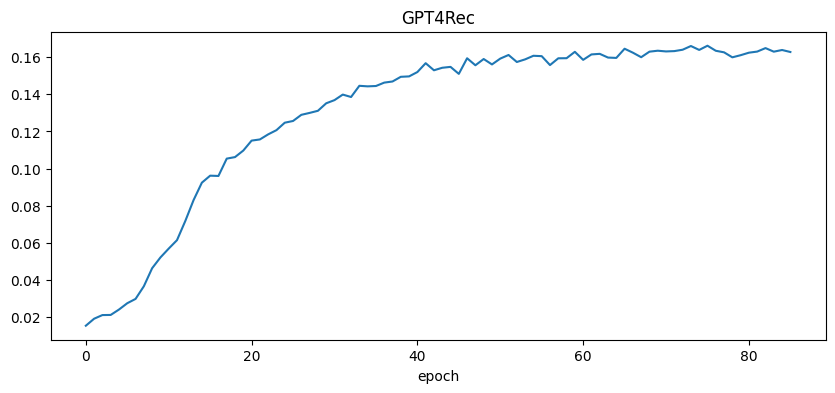

In [57]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
display(history)
history.set_index('epoch')['val_ndcg'].plot(figsize=(10,4), title='GPT4Rec')

## Predict

In [58]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

predict_dataset = CausalLMPredictionDataset(test_inputs, max_length=MAX_LENGTH, time_col='timestamp')

predict_loader = DataLoader(
    predict_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

preds = trainer.predict(model=seqrec_module, dataloaders=predict_loader)

recs = preds2recs(preds)
print(recs.shape)
recs.head()

/tmp/ipykernel_473025/2883154291.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
LOCA

Output()

(6040, 3)


,user_id,item_id,prediction
0,1,364,8.628982
1,1,2081,7.262435
2,1,2087,7.110536
3,1,1688,7.100200
4,1,2096,7.005536


In [59]:
%%time
evaluator = Evaluator()
metrics = evaluator.compute_metrics(test_last_item, recs, train)
metrics

CPU times: user 449 ms, sys: 111 ms, total: 560 ms
Wall time: 553 ms


{'map@10': 0.10026542625880375,
 'ndcg@10': 0.13627459649037582,
 'recall@10': 0.25496688741721857,
 'precision@10': 0.02549668874172185,
 'coverage@10': 0.388101195440645,
 'entropy@10': 9.754812704778685,
 'novelty@10': 10.613917270103284}

## Save

In [60]:
# torch.save(seqrec_module.model, os.path.join(MODEL_SAVE_PATH, 'gpt_64_1_1.pt'))
# torch.save(seqrec_module.model, os.path.join(MODEL_SAVE_PATH, 'gpt_64_2_2.pt'))

In [24]:
# torch.save(seqrec_module.model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'gpt_64_1_1.pt'))